# Bayesian Logisitic Regression

Classification problem by mapping a linear model to a logistic function.

In [1]:
# Modeling
using Turing, Distributions

# Data
using RDatasets

# Viz, diagnostics
using MCMCChains, Plots, StatsPlots

# Logistic function
using StatsFuns: logistic

# Utils
using MLDataUtils: shuffleobs, stratifiedobs, rescale!

# random
using Random
Random.seed!(0);

In [2]:
data = RDatasets.dataset("ISLR", "Default")

first(data, 6)

,Default,Student,Balance,Income
,Cat…,Cat…,Float64,Float64
1,No,No,729.526,44361.6
2,No,Yes,817.18,12106.1
3,No,No,1073.55,31767.1
4,No,No,529.251,35704.5
5,No,No,785.656,38463.5
6,No,Yes,919.589,7491.56


Data shows information if a person is defaulting on a loan based on information about them

Need to encode binaries.

In [3]:
# Generate encoded 
data[!, :DefaultNum] = [r.Default == "Yes" ? 1.0 : 0.0 for r in eachrow(data)]
data[!, :StudentNum] = [r.Student == "Yes" ? 1.0 : 0.0 for r in eachrow(data)]

# Delete old
select!(data, Not([:Default, :Student]))

first(data,6)

,Balance,Income,DefaultNum,StudentNum
,Float64,Float64,Float64,Float64
1,729.526,44361.6,0.0,0.0
2,817.18,12106.1,0.0,1.0
3,1073.55,31767.1,0.0,0.0
4,529.251,35704.5,0.0,0.0
5,785.656,38463.5,0.0,0.0
6,919.589,7491.56,0.0,1.0


Next, train/test split. We're going to aggressively split to highlight the power of Bayesian inference.

Additionally, rescale variables to center around 0 with std 1. `MLDataUtils` has nice functions to shuffle, `shuffleobs`, and get representative samples, `stratifiedobs`.

In [4]:
function split_data(df, target; at = 0.70)
    shuffled = shuffleobs(df)
    trainset, testset = stratifiedobs(
        row->row[target],
        shuffled,
        p=at
    )
end

features = [:StudentNum, :Balance, :Income]
numerics = [:Balance, :Income] # Non-categorical
target = :DefaultNum

trainset, testset = split_data(data, target, at=0.05)
for feature in numerics
    μ, σ = rescale!(trainset[!, feature], obsdim=1)
    rescale!(testset[!,feature], μ, σ, obsdim=1)
end

# Turing needs to convert to matrices
train = Matrix(trainset[:, features])
test = Matrix(testset[:, features])
train_labels = trainset[:, target]
test_labels = testset[:, target];

### Model Construction

Define a `logistic_regression` function, with 4 parameters:

- Independent variables, `x`
- Target, `y`
- Number of observations, `n`
- Prior std, $\sigma$

In [5]:
@model logistic_regression(x, y, n, σ) = begin
    
    intercept ~ Normal(0, σ)
    
    student ~ Normal(0, σ)
    balance ~ Normal(0, σ)
    income ~ Normal(0, σ)    
    
    for i = 1:n
        v = logistic(intercept + student * x[i,1] + balance * x[i,2] + income * x[i,3])
        y[i] ~ Bernoulli(v)
    end
end;

Next, sample using HMC

In [6]:
# Observation
n, _ = size(train)

# Sample
prior_std=1.0
chain = mapreduce(c -> sample(logistic_regression(train, train_labels, n, prior_std), HMC(0.05, 10), 1500),
    chainscat,
    1:3
)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:16
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:14
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:24


Chains MCMC chain (1500×13×3 Array{Float64,3}):

Iterations        = 1:1500
Thinning interval = 1
Chains            = 1, 2, 3
Samples per chain = 1500
parameters        = balance, income, intercept, student
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, n_steps, nom_step_size, step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat  
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64  
                                                                             
     balance    1.6509    0.3114     0.0046    0.0088   1519.5913    1.0020  
      income   -0.5159    0.3321     0.0050    0.0081   1576.8479    1.0003  
   intercept   -3.8211    0.4919     0.0073    0.0153   1190.4604    1.0032  
     student   -1.8676    0.6207     0.0093    0.0226    795.0116    1.0024  

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5%  
      

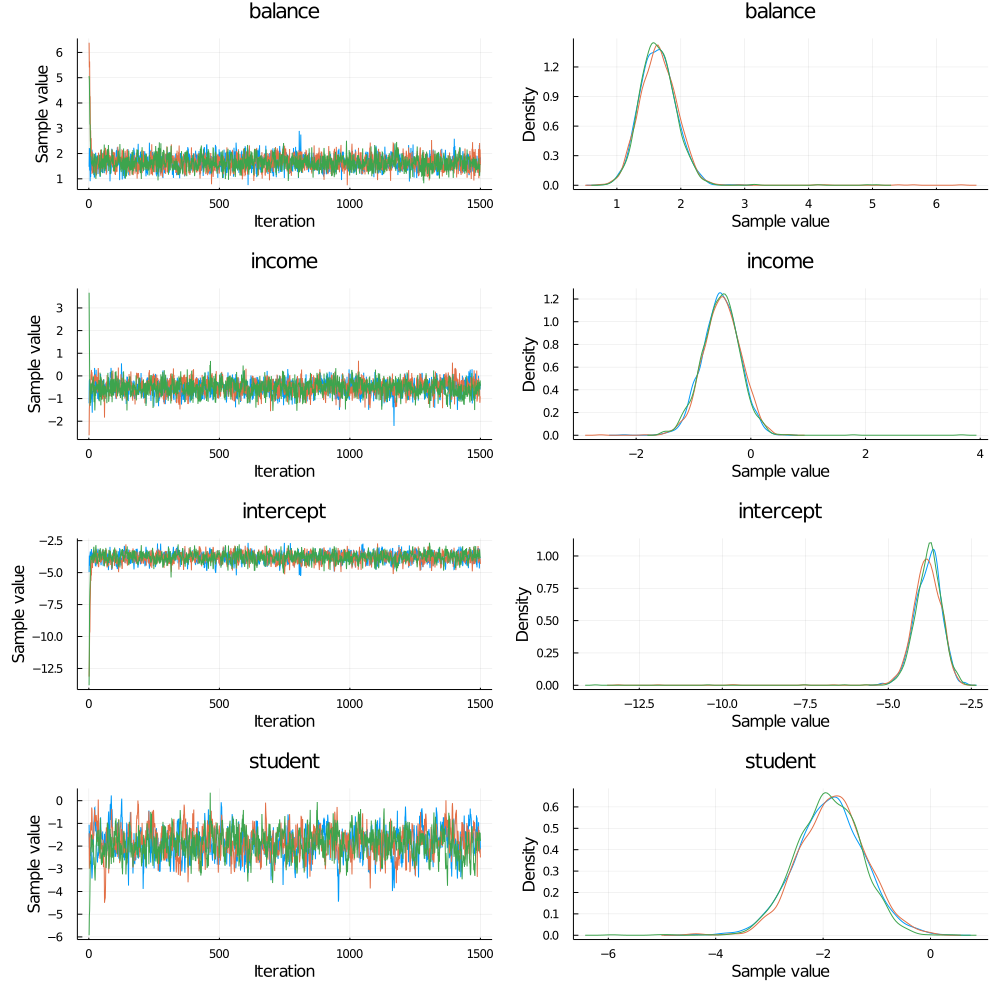

In [7]:
plot(chain)

Convergence looks good. We can use `corner` from `MCMCChains` to show distributions

In [8]:
labels = [:student, :balance, :income]

corner(chain, labels)

Since everything is generally unimodal, this is okay.

### Predictions

Next we need to test the model, using the `prediction` function

In [9]:
function prediction(x::Matrix, chain, threshold)
    # Get means of each parameter
    intercept = mean(chain[:intercept])
    student = mean(chain[:student])
    balance = mean(chain[:balance])
    income = mean(chain[:income])    
    
    # Number of rows
    n, _ = size(x)
    
    # Vector of predictions
    v = Vector{Float64}(undef, n)
    
    # Calculate logistic for each element
    for i in 1:n
        num = logistic(intercept .+ student * x[i,1] + balance * x[i,2] + income * x[i,3])
        if num >= threshold
            v[i] = 1
        else
            v[i] = 0
        end
    end
    return v
end;

Choose a threshold, try 0.07, and make predictions

In [10]:
# Set the prediction threshold.
threshold = 0.07

# Make the predictions.
predictions = prediction(test, chain, threshold)

# Calculate MSE for our test set.
loss = sum((predictions - test_labels).^2) / length(test_labels)

0.11694736842105263

In [11]:
defaults = sum(test_labels)
not_defaults = length(test_labels) - defaults

predicted_defaults = sum(test_labels .== predictions .== 1)
predicted_not_defaults = sum(test_labels .== predictions .== 0)

println("Defaults: $defaults
    Predictions: $predicted_defaults
    Precentage correct: $(predicted_defaults/defaults)
    ")

println("Not defaults: $not_defaults
    Predictions: $predicted_not_defaults
    Precentage non-defaults correct $(predicted_not_defaults/not_defaults)
    ")

Defaults: 316.0
    Predictions: 265
    Precentage correct: 0.8386075949367089
    
Not defaults: 9184.0
    Predictions: 8124
    Precentage non-defaults correct 0.884581881533101
    
